In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('../../data/tests/Diet_R.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Person        78 non-null     int64  
 1   gender        78 non-null     object 
 2   Age           78 non-null     int64  
 3   Height        78 non-null     int64  
 4   pre.weight    78 non-null     int64  
 5   Diet          78 non-null     int64  
 6   weight6weeks  78 non-null     float64
dtypes: float64(1), int64(5), object(1)
memory usage: 4.4+ KB


In [4]:
df.head(5)

,Person,gender,Age,Height,pre.weight,Diet,weight6weeks
0,25,,41,171,60,2,60.0
1,26,,32,174,103,2,103.0
2,1,0,22,159,58,1,54.2
3,2,0,46,192,60,1,54.0
4,3,0,55,170,64,1,63.3


In [5]:
df['weight.lost'] = df['pre.weight'] - df['weight6weeks']
df.head(5)

,Person,gender,Age,Height,pre.weight,Diet,weight6weeks,weight.lost
0,25,,41,171,60,2,60.0,0.0
1,26,,32,174,103,2,103.0,0.0
2,1,0,22,159,58,1,54.2,3.8
3,2,0,46,192,60,1,54.0,6.0
4,3,0,55,170,64,1,63.3,0.7


In [6]:
weight_loss_data = np.array([
    np.array(df.groupby(['Diet'])['weight.lost'].mean()),
    np.array(df.groupby(['Diet'])['weight.lost'].std())
    ]
)

pd.DataFrame(data = weight_loss_data, index = ['Mean', 'STD'], columns = ['Diet 1', 'Diet 2', 'Diet 3']).transpose()

,Mean,STD
Diet 1,3.300000,2.240148
Diet 2,3.025926,2.523367
Diet 3,5.148148,2.395568


### Normality Check
The ANOVA test assumes normality, so we must check if the weight lost for each diet are normally distributed.

In [7]:
for i in range(1,4):
    print (f"Shaprio p-value for Diet {i}: {stats.shapiro(df[df['Diet'] == i]['weight.lost'])[1]}")

Shaprio p-value for Diet 1: 0.07748671621084213
Shaprio p-value for Diet 2: 0.961176335811615
Shaprio p-value for Diet 3: 0.37203603982925415


Each p-value is greater than .05, so we can assume the data are normally distributed.

### Bartlett Test for Variance

Because the data are normally distributed, we can use the Bartlett test for homogeneity of variance.

From [this link](https://www.itl.nist.gov/div898/handbook/eda/section3/eda357.htm):

"Bartlett's test (Snedecor and Cochran, 1983) is used to test if k samples have equal variances. Some statistical tests, for example the analysis of variance, assume that variances are equal across groups or samples. The Bartlett test can be used to verify that assumption.

Bartlett's test is sensitive to departures from normality. That is, if your samples come from non-normal distributions, then Bartlett's test may simply be testing for non-normality. The Levene test is an alternative to the Bartlett test that is less sensitive to departures from normality."

In [8]:
stats.bartlett(df[df['Diet'] == 1]['weight.lost'],
               df[df['Diet'] == 2]['weight.lost'],
               df[df['Diet'] == 3]['weight.lost'])

BartlettResult(statistic=0.337454630479139, pvalue=0.8447392194944549)

Because the pvalue is greater than .05, we can not reject the null hypothesis (the variances are equal).

### Levene Test for Variance

From [this link](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35a.htm)

"Levene's test is an alternative to the Bartlett test. The Levene test is less sensitive than the Bartlett test to departures from normality. If you have strong evidence that your data do in fact come from a normal, or nearly normal, distribution, then Bartlett's test has better performance."

Because we have confirmed that the data are normally distributed, and have verified homogeneity of variance with the Bartlett test, this is mostly for reference. 

In [9]:
stats.levene(df[df['Diet'] == 1]['weight.lost'],
             df[df['Diet'] == 2]['weight.lost'],
             df[df['Diet'] == 3]['weight.lost'],
             center = 'mean')

LeveneResult(statistic=0.6589025222174966, pvalue=0.5203879185139708)

In [10]:
stats.levene(df[df['Diet'] == 1]['weight.lost'],
             df[df['Diet'] == 2]['weight.lost'],
             df[df['Diet'] == 3]['weight.lost'],
             center = 'median')

LeveneResult(statistic=0.6256665777896312, pvalue=0.5376731304274011)

Each test gives a p-value greater than .05, so we can assume similar variance for each diet.

### Visualizing the Data

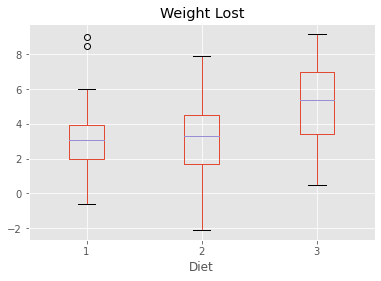

In [11]:
df.boxplot(column = 'weight.lost', by = 'Diet')
plt.title('Weight Lost')
plt.suptitle('') # Removes 'Boxplot grouped by Diet'
plt.show()

### ANOVA Test

From [this link](https://www.pythonfordatascience.org/anova-python/)

"ANOVA stands for "Analysis of Variance" and is an omnibus test, meaning it tests for a difference overall between all groups. The one-way ANOVA, also referred to as one factor ANOVA, is a parametric test used to test for a statistically significant difference of an outcome between 3 or more groups. Since it is an omnibus test, it tests for a difference overall, i.e. at least one of the groups is statistically significantly different than the others. However, if the ANOVA is significant one cannot tell which group is different. In order to tell which group is different, one has to conduct planned or post-hoc comparisons.

The reason why it's called an one-way or one factor ANOVA even though there are 3 or more groups being tested is because those groups are under one categorical variable, such as race or education level, and the name is referring to the number of variables in the analysis and not the number of groups."

Also, from the scipy docs,

"The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean."

In [12]:
stats.f_oneway(df[df['Diet'] == 1]['weight.lost'],
               df[df['Diet'] == 2]['weight.lost'],
               df[df['Diet'] == 3]['weight.lost'])

F_onewayResult(statistic=6.197447453165349, pvalue=0.0032290142385893524)

Because the pvalue is less than .05, we can assume that one of the groups does not have the same population mean. While we may be able to see which diet has a different population mean based on the visualization, it is best to run a post hoc test to determine where the differences are in the diets.

### Post Hoc Test

From [this link](https://www.statisticshowto.com/tukey-test-honest-significant-difference/)

"The Tukey Test (or Tukey procedure), also called Tukey’s Honest Significant Difference test, is a post-hoc test based on the studentized range distribution. An ANOVA test can tell you if your results are significant overall, but it won’t tell you exactly where those differences lie. After you have run an ANOVA and found significant results, then you can run Tukey’s HSD to find out which specific groups’s means (compared with each other) are different. The test compares all possible pairs of means."

In [13]:
diet_tukey = pairwise_tukeyhsd(endog = df['weight.lost'],
                               groups = df['Diet'],
                               alpha = 0.05)
print (diet_tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.2741    0.9 -1.8806 1.3325  False
     1      3   1.8481 0.0201  0.2416 3.4547   True
     2      3   2.1222 0.0048  0.5636 3.6808   True
---------------------------------------------------


Now, we can conclude that there are significant differences between diets 1 and 3, and between diets 2 and 3.